# t-SNE and LDA: topic modelling guide

This tutorial will show how to reproduce what DELab has done in its topic modelling exercise on tech articles: https://towardsdatascience.com/mapping-the-tech-world-with-t-sne-7be8e1703137


https://fwd.delabapps.eu/topic_modelling.html

The packages required are:
* [openTSNE](https://opentsne.readthedocs.io/en/latest/). There are multiple other implementations of t-SNE, including sklearn's more common one, or FIt-SNE: a faster implementation. We feel that openTSNE is just the right balance between easy-to-use, fast and powerful.
* pandas, numpy, scikit-learn (data processing)
* matplotlib, plotly (visualization)

All other libraries used are included in default Python.

# You need to run the following cells:

### Transformation

This cell creates pickle files, one with articles from chosen sources (some columns from source files are removed), one with True/False values whether a particular article contains the test_word. Files are sorted to maintain comparability across machines.

In [1]:
from main_settings import res, sources, text_column, date_column, name,\
test_word, svd_dimensions, min_count_value, perps
import pandas as pd
import numpy as np
import pickle
import os
from ast import literal_eval
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from datetime import datetime
from openTSNE import TSNEEmbedding, affinity, initialization, TSNE
from openTSNE.callbacks import ErrorLogger
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from plotly.offline import plot

In [2]:
text_column

'body'

In [3]:
df = pd.read_pickle(res + 'data_all.pickle')
df = df.reset_index(drop=True)
df[text_column + '_token_count'] = df[text_column + '_token_count'].apply(literal_eval)
for col in [x for x in df.columns if x != text_column + '_token_count' and str(x).startswith(text_column)]:
    print(col)
    del df[col]

df.sort_values(date_column, inplace=True)
df.to_pickle(os.path.join(res, '{}_df.pickle'.format(name)))
facebook_in = df[text_column + '_token_count'].apply(lambda x: test_word in x).values
pickle.dump(facebook_in, open(os.path.join(res, '{}_word_indices.pickle'.format(name)), 'wb'))

body
body_paragraph
body_token
body_token_lower
body_token_stemmed


### tf-idf and SVD
First, [tf-idf transformation](https://en.wikipedia.org/wiki/Information_retrieval) is computed on the term-document matrix. We restrict the words so that only more common ones are taken into account: rare words may introduce noise and increase memory requirements for the very next step. Then it is transformed by [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition) to reduce the number of dimesions, as set in main_settings.

In [4]:
df

index  Unnamed: 0      site  \
0         0           0  guardian   
1         1           1  guardian   
2         2           2  guardian   
3         3           3  guardian   
4         4           4  guardian   
...     ...         ...       ...   
7925     68        7925  guardian   
7929     72        7929  guardian   
7931     74        7931  guardian   
7930     73        7930  guardian   
7932     75        7932  guardian   

                                                    url year_month  \
0     https://www.theguardian.com/technology/2015/de...    2016-01   
1     https://www.theguardian.com/technology/2016/ja...    2016-01   
2     https://www.theguardian.com/technology/2016/ja...    2016-01   
3     https://www.theguardian.com/technology/2016/ja...    2016-01   
4     https://www.theguardian.com/technology/2016/ja...    2016-01   
...                                                 ...        ...   
7925  https://www.theguardian.com/technology/2021/no...    2021-11   
7929  https://www.theguardian.com/technology/2021/no...    2021-11   
7931  https://www.theguardian.com/technology/2021/no...    2021-11   
7930  https://www.theguardian.com/technology/2021/no...    2021-11   
7932  https://www.theguardian.com/technology/2021/no...    2021-11   

       full_date                                   body_token_count         0  \
0     2016-01-01  {'ian': 4, 'murdock': 8, 'a': 14, 'tribut': 1,...  0.253735   
1     2016-01-01  {'appl': 17, 'adblock': 3, 'softwar': 4, 'adbl...  0.203318   
2     2016-01-02  {'is': 22, 'facebook': 5, 'the': 103, 'enemi':...  0.128116   
3     2016-01-02  {'on': 4, 'the': 27, 'road': 2, 'smart': 4, 'c...  2.234564   
4     2016-01-02  {'ces': 13, '2016': 2, 'car': 12, 'virtual': 7...  1.326544   
...          ...                                                ...       ...   
7925  2021-11-29  {'jack': 4, 'dorsey': 15, 'jack_dorsey': 1, 's...  0.110011   
7929  2021-11-29  {'us': 3, 'facial': 6, 'recognit': 4, 'facial_...  0.000000   
7931  2021-11-30  {'elizabeth': 3, 'holm': 21, 'elizabeth_holm':...  0.000000   
7930  2021-11-30  {'who': 8, 'is': 7, 'parag': 2, 'agraw': 11, '...  0.000000   
7932  2021-11-30  {'uk': 6, 'competit': 6, 'watchdog': 2, 'compe...  0.739944   

             1         6  ...        17    3   13         5    9   11   16  \
0     0.509036  1.408413  ...  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0   
1     0.000000  1.630178  ...  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0   
2     0.613534  0.963678  ...  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0   
3     1.034044  0.894490  ...  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0   
4     0.724033  1.449158  ...  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0   
...        ...       ...  ...       ...  ...  ...       ...  ...  ...  ...   
7925  1.248101  0.621584  ...  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0   
7929  0.000000  0.234301  ...  1.670345  0.0  0.0  0.000000  0.0  0.0  0.0   
7931  0.880515  0.930064  ...  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0   
7930  1.976517  0.393955  ...  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0   
7932  0.000000  0.219544  ...  0.000000  0.0  0.0  0.580273  0.0  0.0  0.0   

        4  maxshare  maxtopic  
0     0.0         6        12  
1     0.0         6         6  
2     0.0         7        19  
3     0.0        12        12  
4     0.0         6         6  
...   ...       ...       ...  
7925  0.0         7         2  
7929  0.0         7         8  
7931  0.0         7        14  
7930  0.0         7         1  
7932  0.0         7         7  

[7933 rows x 29 columns]

In [5]:
df = pd.read_pickle(os.path.join(res, '{}_df.pickle'.format(name)))
print(df.columns)
v = DictVectorizer()
X = v.fit_transform(df[text_column + '_token_count'])
alls = pd.DataFrame()
    
indices_min_count = np.where((X > 0).sum(axis=0) >= min_count_value)[1]
X_sh = X.tocsc()[:, indices_min_count]
    
print('start', datetime.now())
tfidf = TfidfTransformer()
X_sh_tfidf = tfidf.fit_transform(X_sh)
print('tfidf fit done', datetime.now())
svd = TruncatedSVD(n_components=svd_dimensions, random_state=2019)
X_svd = svd.fit_transform(X_sh_tfidf)
print('svd fit done', datetime.now())
pickle.dump(X_svd, open(os.path.join(res, '{}_X_svd.pickle'.format(name)), 'wb'))

norms = Normalizer()
X_svd_norm = norms.fit_transform(X_svd)
pickle.dump(X_svd_norm, open(os.path.join(res, '{}_X_svd_norm.pickle'.format(name)), 'wb'))

Index([           'index',       'Unnamed: 0',             'site',
                    'url',       'year_month',        'full_date',
       'body_token_count',                  0,                  1,
                        6,                  7,                 12,
                       15,                 18,                 19,
                        2,                  8,                 10,
                       14,                 17,                  3,
                       13,                  5,                  9,
                       11,                 16,                  4,
               'maxshare',         'maxtopic'],
      dtype='object')
start 2021-12-22 18:36:34.506059
tfidf fit done 2021-12-22 18:36:34.652763
svd fit done 2021-12-22 18:36:58.428619


### t-SNE
As the main cell, it does all the t-SNE transformations required. It uses two perplexity values and settings in general as in [official example in openTSNE](https://github.com/pavlin-policar/openTSNE/blob/master/docs/source/examples/03_preserving_global_structure/03_preserving_global_structure.rst). First, it creates an embedding with a chosen initialization. Random distributes points randomly across the two-dimensional space, PCA is Principal Component Analysis – which is not sufficient on its own to create a valuable 2-D visualization, but is helpful as a starting point, as iterations should converge quicker and crucially with more global structure maintained. Global structure is also the goal of multiple perplexity values: the first training with high perplexity is supposed to find the larger clusters, the second with the smaller value finds smaller structure: subtopics.

The figures below show the evolution of the clusters: 
- we begin with a cloud in the middle (points placed randomly or with PCA)
- T-sne with high perplexity with 250 iterations
- T-sne with high perplexity with 750 iterations
- T-sne with low perplexity with 500 iterations

With the final trainings we can see smaller, local structures in the data 




In [6]:
print('Perlexity values:'+str(perps))

Perlexity values:[300, 25]


random 2021-12-22 18:36:59.202530


/home/delab/miniconda3/envs/tutorials/lib/python3.7/site-packages/pynndescent/pynndescent_.py:177: NumbaPerformanceWarning:


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/tutorials/lib/python3.7/site-packages/pynndescent/utils.py", line 79:
@numba.njit(parallel=True)
def rejection_sample(n_samples, pool_size, rng_state):
^


/home/delab/miniconda3/envs/tutorials/lib/python3.7/site-packages/pynndescent/pynndescent_.py:199: NumbaPerformanceWarning:


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/tutorials/lib/python3.7/site-p

perplexity nn done 2021-12-22 18:37:25.707510
embedding done 2021-12-22 18:37:25.707673


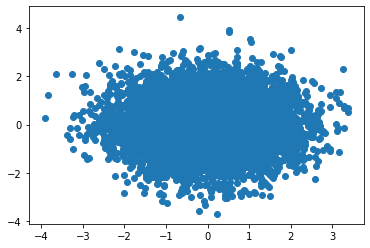

0 -3.9224002516183423 3.377768241289362
Iteration   50, KL divergence  2.0910, 50 iterations in 4.4059 sec
Iteration  100, KL divergence  1.6550, 50 iterations in 4.3520 sec
Iteration  150, KL divergence  1.5159, 50 iterations in 4.2808 sec
Iteration  200, KL divergence  1.4522, 50 iterations in 4.4128 sec
Iteration  250, KL divergence  1.4214, 50 iterations in 4.4596 sec


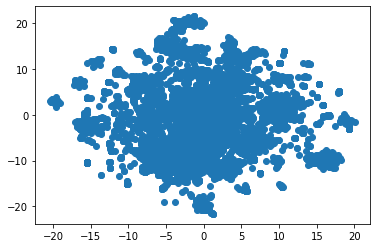

1 -20.34694503913809 20.030207229863628
Iteration   50, KL divergence  1.3891, 50 iterations in 4.4198 sec
Iteration  100, KL divergence  1.3820, 50 iterations in 4.7804 sec
Iteration  150, KL divergence  1.3776, 50 iterations in 4.8986 sec
Iteration  200, KL divergence  1.3750, 50 iterations in 5.0545 sec
Iteration  250, KL divergence  1.3725, 50 iterations in 5.6817 sec
Iteration  300, KL divergence  1.3698, 50 iterations in 5.0258 sec
Iteration  350, KL divergence  1.3681, 50 iterations in 4.5720 sec
Iteration  400, KL divergence  1.3666, 50 iterations in 4.3924 sec
Iteration  450, KL divergence  1.3649, 50 iterations in 4.6324 sec
Iteration  500, KL divergence  1.3644, 50 iterations in 4.6322 sec
Iteration  550, KL divergence  1.3614, 50 iterations in 5.2015 sec
Iteration  600, KL divergence  1.3607, 50 iterations in 6.5132 sec
Iteration  650, KL divergence  1.3592, 50 iterations in 5.7923 sec
Iteration  700, KL divergence  1.3585, 50 iterations in 5.0153 sec
Iteration  750, KL div

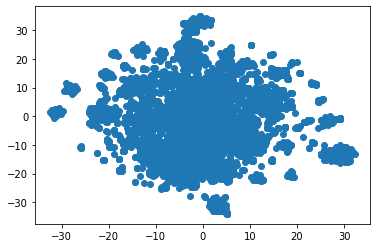

2 -32.35111088495343 32.273304281157834
Iteration   50, KL divergence  2.1077, 50 iterations in 2.9844 sec
Iteration  100, KL divergence  2.0252, 50 iterations in 3.9482 sec
Iteration  150, KL divergence  1.9493, 50 iterations in 4.2026 sec
Iteration  200, KL divergence  1.8933, 50 iterations in 4.5653 sec
Iteration  250, KL divergence  1.8596, 50 iterations in 5.7559 sec
Iteration  300, KL divergence  1.8345, 50 iterations in 6.9136 sec
Iteration  350, KL divergence  1.8136, 50 iterations in 5.6907 sec
Iteration  400, KL divergence  1.7974, 50 iterations in 7.9699 sec
Iteration  450, KL divergence  1.7797, 50 iterations in 7.4594 sec
Iteration  500, KL divergence  1.7686, 50 iterations in 7.5023 sec


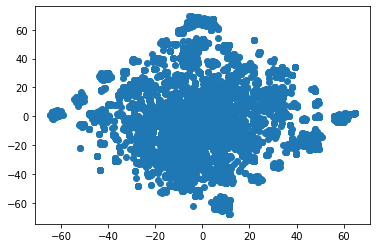

3 -64.47437524137936 64.67000576104
embedding optimize done 2021-12-22 18:40:01.882361
pca 2021-12-22 18:40:01.893500


/home/delab/miniconda3/envs/tutorials/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning:


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/tutorials/lib/python3.7/site-packages/pynndescent/pynndescent_.py", line 38:
    @numba.njit(parallel=True, fastmath=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^


/home/delab/miniconda3/envs/tutorials/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning:


The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../

perplexity nn done 2021-12-22 18:40:22.327594
embedding done 2021-12-22 18:40:22.327737


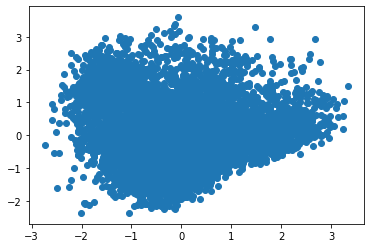

0 -2.740208581059669 3.339738460229899
Iteration   50, KL divergence  1.7385, 50 iterations in 4.3444 sec
Iteration  100, KL divergence  1.4766, 50 iterations in 4.4829 sec
Iteration  150, KL divergence  1.3738, 50 iterations in 4.3526 sec
Iteration  200, KL divergence  1.3229, 50 iterations in 4.4007 sec
Iteration  250, KL divergence  1.2961, 50 iterations in 4.4118 sec


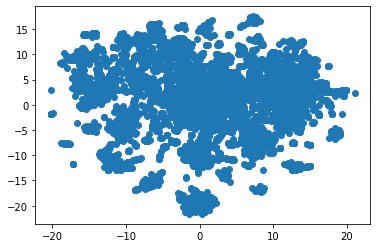

1 -20.252540107272107 21.08771022011251
Iteration   50, KL divergence  1.2723, 50 iterations in 4.3857 sec
Iteration  100, KL divergence  1.2635, 50 iterations in 4.9134 sec
Iteration  150, KL divergence  1.2614, 50 iterations in 4.4799 sec
Iteration  200, KL divergence  1.2602, 50 iterations in 4.8018 sec
Iteration  250, KL divergence  1.2584, 50 iterations in 4.5027 sec
Iteration  300, KL divergence  1.2568, 50 iterations in 4.7862 sec
Iteration  350, KL divergence  1.2562, 50 iterations in 5.0033 sec
Iteration  400, KL divergence  1.2550, 50 iterations in 5.5431 sec
Iteration  450, KL divergence  1.2542, 50 iterations in 4.6319 sec
Iteration  500, KL divergence  1.2535, 50 iterations in 5.8552 sec
Iteration  550, KL divergence  1.2530, 50 iterations in 5.3911 sec
Iteration  600, KL divergence  1.2534, 50 iterations in 5.2060 sec
Iteration  650, KL divergence  1.2526, 50 iterations in 4.4496 sec
Iteration  700, KL divergence  1.2516, 50 iterations in 4.5415 sec
Iteration  750, KL div

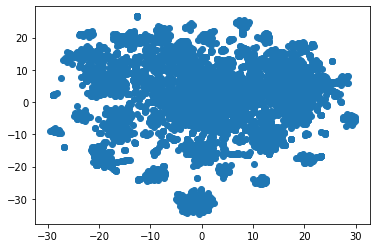

2 -29.48556060977448 29.82913706394608
Iteration   50, KL divergence  1.9810, 50 iterations in 2.6128 sec
Iteration  100, KL divergence  1.8992, 50 iterations in 3.7966 sec
Iteration  150, KL divergence  1.8242, 50 iterations in 4.0711 sec
Iteration  200, KL divergence  1.7660, 50 iterations in 4.4108 sec
Iteration  250, KL divergence  1.7271, 50 iterations in 5.0795 sec
Iteration  300, KL divergence  1.7040, 50 iterations in 7.1847 sec
Iteration  350, KL divergence  1.6874, 50 iterations in 5.8281 sec
Iteration  400, KL divergence  1.6716, 50 iterations in 5.6940 sec
Iteration  450, KL divergence  1.6554, 50 iterations in 9.3236 sec
Iteration  500, KL divergence  1.6426, 50 iterations in 5.6051 sec


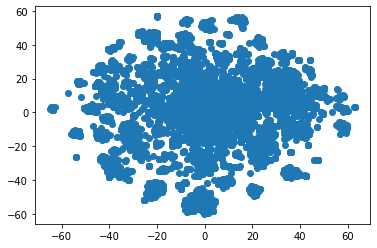

3 -64.68977827904455 62.86624533895973
embedding optimize done 2021-12-22 18:42:52.399301


In [7]:
X_svd = pd.read_pickle(os.path.join(res, '{}_X_svd.pickle'.format(name)))
for init_name, init_train in {
    'random': initialization.random(X_svd, random_state=42),
    'pca': initialization.pca(X_svd, random_state=42)
}.items():
    print(init_name, datetime.now())
    affinities_train = affinity.PerplexityBasedNN(
    X_svd, perplexity=perps[0], metric='cosine', n_jobs=1, random_state=42)
    print('perplexity nn done', datetime.now())
    embedding_train = TSNEEmbedding(
        init_train,
        affinities_train,
        negative_gradient_method="fft",
        n_jobs=3,
        callbacks=ErrorLogger()
    )
    print('embedding done', datetime.now())
    embedding_train[:, 0] *= 100
    embedding_train[:, 1] *= 100
    plt.scatter(embedding_train[:,0], embedding_train[:,1])
    plt.show()
    plt.close()
    print('0', np.min(embedding_train[:,0]), np.max(embedding_train[:,0]))
    embedding_train_1 = embedding_train.optimize(n_iter=250, momentum=0.5)
    plt.scatter(embedding_train_1[:,0], embedding_train_1[:,1])
    plt.show()
    plt.close()
    print('1', np.min(embedding_train_1[:,0]), np.max(embedding_train_1[:,0]))
    embedding_train_2 = embedding_train_1.optimize(n_iter=750, momentum=0.8)
    plt.scatter(embedding_train_2[:,0], embedding_train_2[:,1])
    plt.show()
    plt.close()
    print('2', np.min(embedding_train_2[:,0]), np.max(embedding_train_2[:,0]))
    affinities_train.set_perplexity(perps[1])
    embedding_train_3 = embedding_train_2.optimize(n_iter=500, momentum=0.8)
    plt.scatter(embedding_train_3[:,0], embedding_train_3[:,1])
    plt.show()
    plt.close()
    print('3', np.min(embedding_train_3[:,0]), np.max(embedding_train_3[:,0]))
    print('embedding optimize done', datetime.now())
    pickle.dump(np.array(embedding_train_2.tolist()), open(os.path.join(res, 
        '{}_embedding_{}_{}.pickle'.format(
        name, perps[0], init_name)), 'wb'))
    pickle.dump(np.array(embedding_train_3.tolist()), open(os.path.join(res,
        '{}_embedding_{}_{}_{}.pickle'.format(
        name, perps[0], perps[1], init_name)), 'wb'))

### Analysis

To examine whether the placing of articles in 2D space is meaningful, a preliminary analysis is presented. Let's identify articles that contain the word "Facebook" and see their location.    

In [8]:
embeddings_train = {}
for init_name in ['random', 'pca']:
    embeddings_train[init_name] = pd.read_pickle(os.path.join(res,
                                                              '{}_embedding_{}_{}_{}.pickle'.format(
                                                                 name, perps[0], perps[1], init_name)))
    
facebook_in = pd.read_pickle(os.path.join(res, '{}_word_indices.pickle'.format(name)))


In [9]:
sample_numbers = np.arange(0, embeddings_train['pca'].shape[0])

pca


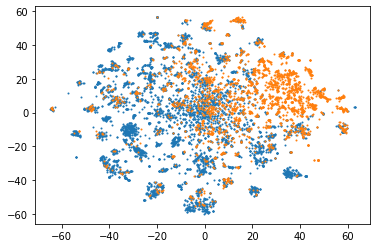

random


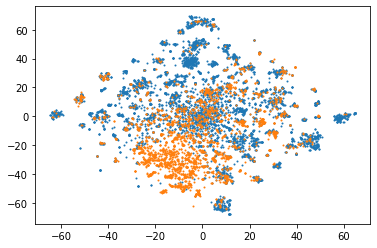

In [10]:
for init_name in ['pca', 'random']:
    print(init_name)
    plt.scatter(x=embeddings_train[init_name][sample_numbers[~facebook_in[sample_numbers]],0],
                y=embeddings_train[init_name][sample_numbers[~facebook_in[sample_numbers]],1],
               s=1)

    plt.scatter(x=embeddings_train[init_name][sample_numbers[facebook_in[sample_numbers]],0],
                y=embeddings_train[init_name][sample_numbers[facebook_in[sample_numbers]],1],
               s=1)
    plt.show()
    plt.close()

Facebook is a general topic, nevertheless PCA seems to do a slightly better job in making the topics related to Facebook be closer to the main topic of Facebook, which is clear for both initializations. Let us try another topics, for example drones and spacex. They are vaguely related – but should clearly be in different clusters. For larger datasets, the improvement by using PCA should be more clear.

In [11]:
df = pd.read_pickle(os.path.join(res, '{}_df.pickle'.format(name)))

In [12]:
indices_1 = df[text_column + '_token_count'].apply(lambda x: 'drone' in x).values
indices_2 = df[text_column + '_token_count'].apply(lambda x: 'spacex' in x).values

In [13]:
sum(indices_1), sum(indices_2)

(227, 109)

pca


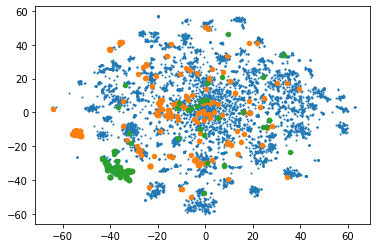

random


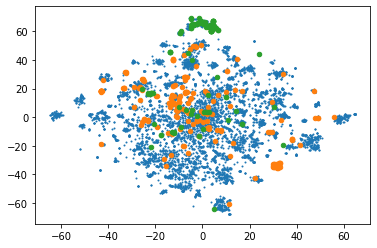

In [14]:
for init_name in ['pca', 'random']:
    print(init_name)
    plt.scatter(x=embeddings_train[init_name][sample_numbers[~indices_1[sample_numbers] & ~indices_2[sample_numbers]],0],
                y=embeddings_train[init_name][sample_numbers[~indices_1[sample_numbers] & ~indices_2[sample_numbers]],1],
               s=1)

    plt.scatter(x=embeddings_train[init_name][sample_numbers[indices_1[sample_numbers]],0],
                y=embeddings_train[init_name][sample_numbers[indices_1[sample_numbers]],1],
               s=20)
    
    plt.scatter(x=embeddings_train[init_name][sample_numbers[indices_2[sample_numbers]],0],
                y=embeddings_train[init_name][sample_numbers[indices_2[sample_numbers]],1],
               s=20)
    plt.show()
    plt.close()

### T-sne with LDA

How do the clusters prepared with T-sne compare to the LDA topics from the previous tutorial? 
Let us now create an interactive visualization. 
The location of the articles is assigned with T-sne, while the colors are determined by the dominant topics assigned in the LDA analysis.


In [15]:
for init_name in ['pca', 'random']:
    df['x_{}'.format(init_name)] = embeddings_train[init_name][:,0]
    df['y_{}'.format(init_name)] = embeddings_train[init_name][:,1]

In [16]:
df_sh = df.iloc[sample_numbers]

In [17]:
df_sh

index  Unnamed: 0      site  \
0         0           0  guardian   
1         1           1  guardian   
2         2           2  guardian   
3         3           3  guardian   
4         4           4  guardian   
...     ...         ...       ...   
7925     68        7925  guardian   
7929     72        7929  guardian   
7931     74        7931  guardian   
7930     73        7930  guardian   
7932     75        7932  guardian   

                                                    url year_month  \
0     https://www.theguardian.com/technology/2015/de...    2016-01   
1     https://www.theguardian.com/technology/2016/ja...    2016-01   
2     https://www.theguardian.com/technology/2016/ja...    2016-01   
3     https://www.theguardian.com/technology/2016/ja...    2016-01   
4     https://www.theguardian.com/technology/2016/ja...    2016-01   
...                                                 ...        ...   
7925  https://www.theguardian.com/technology/2021/no...    2021-11   
7929  https://www.theguardian.com/technology/2021/no...    2021-11   
7931  https://www.theguardian.com/technology/2021/no...    2021-11   
7930  https://www.theguardian.com/technology/2021/no...    2021-11   
7932  https://www.theguardian.com/technology/2021/no...    2021-11   

       full_date                                   body_token_count         0  \
0     2016-01-01  {'ian': 4, 'murdock': 8, 'a': 14, 'tribut': 1,...  0.253735   
1     2016-01-01  {'appl': 17, 'adblock': 3, 'softwar': 4, 'adbl...  0.203318   
2     2016-01-02  {'is': 22, 'facebook': 5, 'the': 103, 'enemi':...  0.128116   
3     2016-01-02  {'on': 4, 'the': 27, 'road': 2, 'smart': 4, 'c...  2.234564   
4     2016-01-02  {'ces': 13, '2016': 2, 'car': 12, 'virtual': 7...  1.326544   
...          ...                                                ...       ...   
7925  2021-11-29  {'jack': 4, 'dorsey': 15, 'jack_dorsey': 1, 's...  0.110011   
7929  2021-11-29  {'us': 3, 'facial': 6, 'recognit': 4, 'facial_...  0.000000   
7931  2021-11-30  {'elizabeth': 3, 'holm': 21, 'elizabeth_holm':...  0.000000   
7930  2021-11-30  {'who': 8, 'is': 7, 'parag': 2, 'agraw': 11, '...  0.000000   
7932  2021-11-30  {'uk': 6, 'competit': 6, 'watchdog': 2, 'compe...  0.739944   

             1         6  ...    9   11   16    4  maxshare  maxtopic  \
0     0.509036  1.408413  ...  0.0  0.0  0.0  0.0         6        12   
1     0.000000  1.630178  ...  0.0  0.0  0.0  0.0         6         6   
2     0.613534  0.963678  ...  0.0  0.0  0.0  0.0         7        19   
3     1.034044  0.894490  ...  0.0  0.0  0.0  0.0        12        12   
4     0.724033  1.449158  ...  0.0  0.0  0.0  0.0         6         6   
...        ...       ...  ...  ...  ...  ...  ...       ...       ...   
7925  1.248101  0.621584  ...  0.0  0.0  0.0  0.0         7         2   
7929  0.000000  0.234301  ...  0.0  0.0  0.0  0.0         7         8   
7931  0.880515  0.930064  ...  0.0  0.0  0.0  0.0         7        14   
7930  1.976517  0.393955  ...  0.0  0.0  0.0  0.0         7         1   
7932  0.000000  0.219544  ...  0.0  0.0  0.0  0.0         7         7   

          x_pca      y_pca   x_random   y_random  
0      0.797319   0.896048  -0.446571  -2.851940  
1     15.141941  36.168356 -19.858249 -17.320443  
2     10.426968   3.716563  -0.771155  -7.108964  
3    -40.822472  -3.309390   4.590102  35.995374  
4    -19.715680   5.331466  -6.929266  17.580421  
...         ...        ...        ...        ...  
7925  41.131720 -14.296416  12.362915 -44.894827  
7929  22.575701  38.873038  20.246967 -41.691199  
7931  -8.983103 -23.497441  -3.228398  22.890712  
7930  41.139286 -14.203596  12.276243 -44.866223  
7932  44.213094  31.168253 -15.232070 -18.086769  

[7933 rows x 33 columns]

To make the visualisation more focused, separate colours are assigned to the 9 most important topics, while the remaining ones will be treated as one topic (named topic 99)


In [18]:
df_sh['maxtopic']=df_sh['maxtopic'].map({k: (k if k not in df_sh['maxtopic'].value_counts()[9:].index else 99) for k in df_sh['maxtopic'].unique()})

In [ ]:
for init_name in ['random', 'pca']:
    all_data = []
    for maxtopic, df_sh_topic in df_sh.groupby('maxtopic'):
        all_data.append({
            'x': df_sh_topic['x_{}'.format(init_name)], 'y': df_sh_topic['y_{}'.format(init_name)],
            'text': df_sh_topic['url'],
            'fillcolor': '#%02x%02x%02x' % cm.viridis(maxtopic, bytes=True)[:-1],
            'mode': 'markers',
            'name': maxtopic,
            'marker': {'size': 5,
                      }
        })

    plot({'data': all_data},
        filename=os.path.join(res, 'all_guardian_{}.html'.format(init_name)))

Two visualisation appear in separate tabs in the browser and are saved locally as well.

You can examine the titles of the articles: articles on the same subject should be close to each other. Similarly to our report (https://fwd.delabapps.eu/topic_modelling.html), the method works very well in identifying small topic clusters, especially outside the centre of the visualisation.

The LDA topics are also meaningful, as small clusters tend to have articles with the same dominant topic, hence the same colour. 

To conclude, LDA is a great tool to identify large topics and characteristic terms. In order to dive deeper in these topics, t-SNE is highly effective.